In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention,
    Add, Activation, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# dataset directory
dataset_dir = "dataset-allin/sorted"

# load and preprocess the dataset
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 1839 files belonging to 3 classes.


In [2]:
# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2):
    total_size = dataset.cardinality().numpy()
    train_dataset = dataset.take(int(total_size * train_size))
    val_test_dataset = dataset.skip(int(total_size * train_size))
    val_dataset = val_test_dataset.take(int(total_size * val_size))
    test_dataset = val_test_dataset.skip(int(total_size * val_size))
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data)

# prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

In [3]:
# Get class names and compute class weights for focal loss

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Collect all labels from the training set
train_labels = []
for _, labels in train:
    train_labels.extend(labels.numpy())
train_labels = np.array(train_labels)

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.887040887040887), 1: np.float64(0.7872078720787208), 2: np.float64(1.6601815823605708)}


In [4]:
# Advanced augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomFlip(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
])

train = train.map(lambda x, y: (data_augmentation(x), y))

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Add, Input, Reshape, GlobalAveragePooling1D)
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Attention block
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed-forward block
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_hybrid_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # CNN Backbone (feature extractor)
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs, name="resnet50")
    base_model.trainable = False   # fine-tune later if needed

    x = base_model.output  # shape: (7, 7, 2048)
    x = Reshape((49, 2048))(x)  # Flatten spatial grid into sequence

    # Transformer blocks
    for _ in range(2):  # can increase for more power
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    # Pool transformer outputs
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Usage
model = build_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [7]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    # class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4297 - loss: 1.5074 - val_accuracy: 0.5455 - val_loss: 1.0953 - learning_rate: 1.0000e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6016 - loss: 1.1341 - val_accuracy: 0.6562 - val_loss: 0.9171 - learning_rate: 1.0000e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6687 - loss: 0.8874 - val_accuracy: 0.6875 - val_loss: 0.7762 - learning_rate: 1.0000e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7195 - loss: 0.7514 - val_accuracy: 0.6989 - val_loss: 0.8709 - learning_rate: 1.0000e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7289 - loss: 0.7703 - val_accuracy: 0.7159 - val_loss: 0.8566 - learning_rate: 1.0000e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7539 - loss: 0.6749 - val_accuracy: 0.7500 - val_loss: 0.7431 - learning_rate: 1.0000e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7789 - loss:

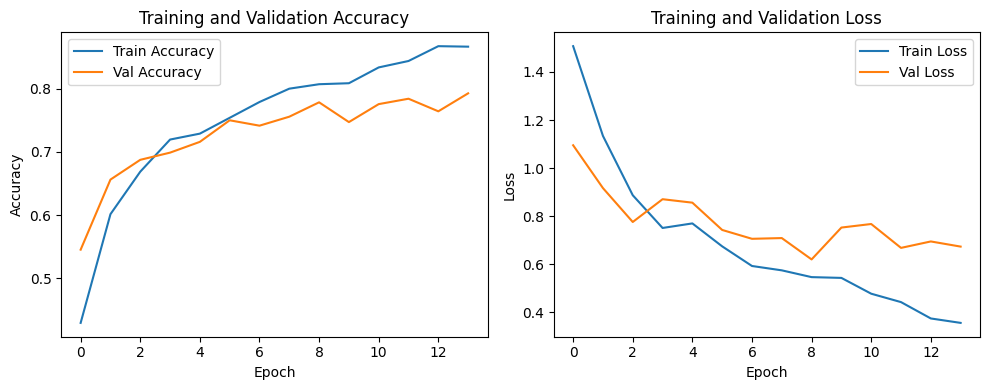

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_vanilla.h5')

In [10]:
# Stage 2: Unfreeze top ResNet layers (last 30 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7766 - loss: 0.5604 - val_accuracy: 0.7670 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8219 - loss: 0.4654 - val_accuracy: 0.8068 - val_loss: 0.6203 - learning_rate: 1.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8242 - loss: 0.4397 - val_accuracy: 0.7614 - val_loss: 0.6595 - learning_rate: 1.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8305 - loss: 0.4216 - val_accuracy: 0.7898 - val_loss: 0.6417 - learning_rate: 1.0000e-05
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8375 - loss: 0.4196 - val_accuracy: 0.7841 - val_loss: 0.5930 - learning_rate: 1.0000e-05
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8578 - loss: 0.3627 - val_accuracy: 0.8011 - val_loss: 0.5350 - learning_rate: 1.0000e-05
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8727 - loss:

In [12]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_30layerscnn.h5')

In [ ]:
# Stage 2: Unfreeze top ResNet layers (last 60 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8148 - loss: 0.4556 - val_accuracy: 0.7756 - val_loss: 0.6247 - learning_rate: 2.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8461 - loss: 0.3789 - val_accuracy: 0.7898 - val_loss: 0.6774 - learning_rate: 2.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8727 - loss: 0.3379 - val_accuracy: 0.7670 - val_loss: 0.6754 - learning_rate: 2.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9016 - loss: 0.2715 - val_accuracy: 0.8295 - val_loss: 0.4756 - learning_rate: 1.0000e-05
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8859 - loss: 0.2927 - val_accuracy: 0.8011 - val_loss: 0.5344 - learning_rate: 1.0000e-05
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9023 - loss: 0.2642 - val_accuracy: 0.7983 - val_loss: 0.5383 - learning_rate: 1.0000e-05
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.8945 - l

In [14]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned60layers.h5')

In [16]:
# Stage 2: Unfreeze top ResNet layers (last 90 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-90:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8773 - loss: 0.3014 - val_accuracy: 0.8153 - val_loss: 0.5014 - learning_rate: 2.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8953 - loss: 0.2625 - val_accuracy: 0.8068 - val_loss: 0.5950 - learning_rate: 2.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8953 - loss: 0.2865 - val_accuracy: 0.8295 - val_loss: 0.4785 - learning_rate: 2.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8969 - loss: 0.2549 - val_accuracy: 0.8324 - val_loss: 0.5387 - learning_rate: 1.0000e-05
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.9031 - loss: 0.2527 - val_accuracy: 0.8125 - val_loss: 0.5866 - learning_rate: 1.0000e-05


In [18]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.8984
Recall: 0.8846
Accuracy: 0.7971


In [17]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned90layers.h5')

In [20]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.8609 - loss: 0.3693 - val_accuracy: 0.8239 - val_loss: 0.5969 - learning_rate: 2.0000e-05
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.8844 - loss: 0.3110 - val_accuracy: 0.8267 - val_loss: 0.6062 - learning_rate: 2.0000e-05
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.8898 - loss: 0.2661 - val_accuracy: 0.8182 - val_loss: 0.5495 - learning_rate: 2.0000e-05
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.9117 - loss: 0.2008 - val_accuracy: 0.8267 - val_loss: 0.4893 - learning_rate: 1.0000e-05
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.9102 - loss: 0.2212 - val_accuracy: 0.8409 - val_loss: 0.5003 - learning_rate: 1.0000e-05


In [21]:

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.9008
Recall: 0.9147
Accuracy: 0.8261


In [ ]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned150layers.h5')

In [23]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-200:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 275s 6s/step - accuracy: 0.8516 - loss: 0.3937 - val_accuracy: 0.8040 - val_loss: 0.7029 - learning_rate: 1.0000e-06
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step - accuracy: 0.8539 - loss: 0.3700 - val_accuracy: 0.8153 - val_loss: 0.6053 - learning_rate: 1.0000e-06
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step - accuracy: 0.8602 - loss: 0.3611 - val_accuracy: 0.8153 - val_loss: 0.5627 - learning_rate: 1.0000e-06
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step - accuracy: 0.8695 - loss: 0.3401 - val_accuracy: 0.8210 - val_loss: 0.5766 - learning_rate: 1.0000e-06
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 222s 6s/step - accuracy: 0.8711 - loss: 0.3088 - val_accuracy: 0.7983 - val_loss: 0.6108 - learning_rate: 1.0000e-06


In [24]:

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.8978
Recall: 0.8913
Accuracy: 0.8454


In [ ]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned200layers.h5')

In [29]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned150layers.h5')

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.9297
Recall: 0.9084
Accuracy: 0.8357


In [41]:
# Load the saved model
model = load_model('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned150layers.h5')

for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
# Unfreeze transformer layers (those after ResNet output)
for layer in model.layers:
    if 'multi_head_attention' in layer.name or 'dense' in layer.name or 'dropout' in layer.name or 'layer_normalization' in layer.name:
        layer.trainable = True

# Recompile with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune transformer layers
history_transformer = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9312 - loss: 0.1961 - val_accuracy: 0.8210 - val_loss: 0.6138 - learning_rate: 1.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9242 - loss: 0.1864 - val_accuracy: 0.8267 - val_loss: 0.6102 - learning_rate: 1.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9164 - loss: 0.2127 - val_accuracy: 0.8182 - val_loss: 0.6043 - learning_rate: 1.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9219 - loss: 0.1934 - val_accuracy: 0.8068 - val_loss: 0.6657 - learning_rate: 5.0000e-06
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9289 - loss: 0.1959 - val_accuracy: 0.8210 - val_loss: 0.6048 - learning_rate: 5.0000e-06


In [42]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precision: 0.9615
Recall: 0.9191
Accuracy: 0.8551


In [43]:
model.save('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetunedtransformerlayers.h5')

In [44]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_stage3 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 352s 6s/step - accuracy: 0.8305 - loss: 0.4127 - val_accuracy: 0.8409 - val_loss: 0.5352 - learning_rate: 1.0000e-06
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 223s 6s/step - accuracy: 0.8336 - loss: 0.4147 - val_accuracy: 0.8239 - val_loss: 0.5662 - learning_rate: 1.0000e-06
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step - accuracy: 0.8672 - loss: 0.3577 - val_accuracy: 0.7955 - val_loss: 0.6404 - learning_rate: 1.0000e-06
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step - accuracy: 0.8625 - loss: 0.3090 - val_accuracy: 0.8068 - val_loss: 0.5959 - learning_rate: 1.0000e-06
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.8609 - loss: 0.3372 - val_accuracy: 0.7869 - val_loss: 0.6333 - learning_rate: 1.0000e-06


In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Precision: 0.8760
Recall: 0.8828
Accuracy: 0.7826


In [46]:
# Load best model weights
model = load_model('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetunedtransformerlayers.h5')

# Define simple TTA (horizontal flip, vertical flip, etc.)
def tta_predict(model, image):
    preds = []
    preds.append(model.predict(tf.expand_dims(image, 0))[0])
    preds.append(model.predict(tf.expand_dims(tf.image.flip_left_right(image), 0))[0])
    preds.append(model.predict(tf.expand_dims(tf.image.flip_up_down(image), 0))[0])
    # Add more augmentations if desired
    return np.mean(preds, axis=0)

# Evaluate with TTA
tta_preds = []
tta_labels = []
for batch in test.as_numpy_iterator():
    X, y = batch
    for img, label in zip(X, y):
        pred = tta_predict(model, img)
        tta_preds.append(np.argmax(pred))
        tta_labels.append(label)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("TTA Precision:", precision_score(tta_labels, tta_preds, average='macro'))
print("TTA Recall:", recall_score(tta_labels, tta_preds, average='macro'))
print("TTA Accuracy:", accuracy_score(tta_labels, tta_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/s

In [47]:
# Load best model weights
model = load_model('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned150layers.h5')

# Define simple TTA (horizontal flip, vertical flip, etc.)
def tta_predict(model, image):
    preds = []
    preds.append(model.predict(tf.expand_dims(image, 0))[0])
    preds.append(model.predict(tf.expand_dims(tf.image.flip_left_right(image), 0))[0])
    preds.append(model.predict(tf.expand_dims(tf.image.flip_up_down(image), 0))[0])
    # Add more augmentations if desired
    return np.mean(preds, axis=0)

# Evaluate with TTA
tta_preds = []
tta_labels = []
for batch in test.as_numpy_iterator():
    X, y = batch
    for img, label in zip(X, y):
        pred = tta_predict(model, img)
        tta_preds.append(np.argmax(pred))
        tta_labels.append(label)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("TTA Precision:", precision_score(tta_labels, tta_preds, average='macro'))
print("TTA Recall:", recall_score(tta_labels, tta_preds, average='macro'))
print("TTA Accuracy:", accuracy_score(tta_labels, tta_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━